# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [3]:
import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Importing dataset

In [4]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val/'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test/'

In [5]:
train_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
train_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"train_num_pneumonia: {train_num_pneumonia}")
print(f"train_num_normal: {train_num_normal}")

val_num_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
val_num_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"val_num_pneumonia: {val_num_pneumonia}")
print(f"val_num_normal: {val_num_normal}")

test_num_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
test_num_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"test_num_pneumonia: {test_num_pneumonia}")
print(f"test_num_normal: {test_num_normal}")

print("")
train_num = train_num_pneumonia+train_num_normal
val_num = val_num_pneumonia+val_num_normal
test_num = test_num_pneumonia+test_num_normal
print(f"train_num: {train_num}")
print(f"val_num: {val_num}")
print(f"test_num: {test_num}")

print("")
num_pneumonia = train_num_pneumonia + test_num_pneumonia + val_num_pneumonia
num_normal = train_num_normal + test_num_normal + val_num_normal
print(f"num_pneumonia: {num_pneumonia}")
print(f"num_normal: {num_normal}")

train_num_pneumonia: 3875
train_num_normal: 1341
val_num_pneumonia: 8
val_num_normal: 8
test_num_pneumonia: 390
test_num_normal: 234

train_num: 5216
val_num: 16
test_num: 624

num_pneumonia: 4273
num_normal: 1583


## Loading data function

In [6]:
labels = ["NORMAL", "PNEUMONIA"]
img_size = 224

def load_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
                
    return np.array(data, dtype="object")

## Loading data

In [7]:
train = load_data(train_dir)
test = load_data(test_dir)
val = load_data(val_dir)

## Splitting X and y

In [8]:
X_train = [] 
y_train = []
X_test = [] 
y_test = []
X_val = [] 
y_val = []

def split_x_y(data, x, y):
    for feature, label in data:
        x.append(feature)
        y.append(label)
    return np.array(x), np.array(y)

X_train, y_train = split_x_y(train, X_train, y_train)
X_test, y_test = split_x_y(test, X_test, y_test)
X_val, y_val = split_x_y(val, X_val, y_val)

# Data augmentation layer

In [9]:
def augmentation_layers(x):
    x = keras.layers.Rescaling(1./255)(x)
    x = keras.layers.RandomRotation(0.05)(x)
    return x

# Visualizing data

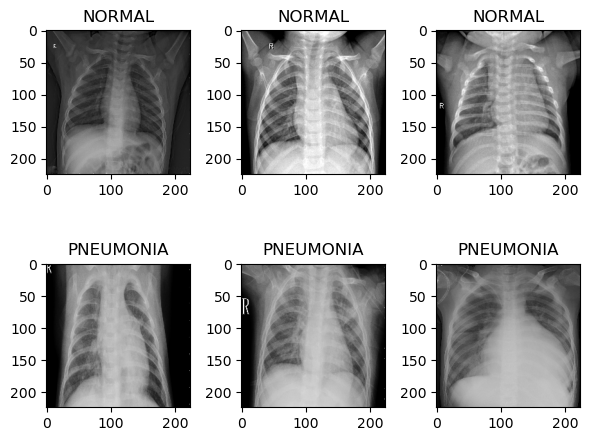

In [10]:
j=0
fig=plt.figure(figsize=(6, 6))
for i in (0,1,2,-2,-3,-4):
    fig.add_subplot(2,3,j+1)
    plt.imshow(train[i][0])
    plt.title(labels[train[i][1]])
    plt.tight_layout()
    j+=1
plt.show()

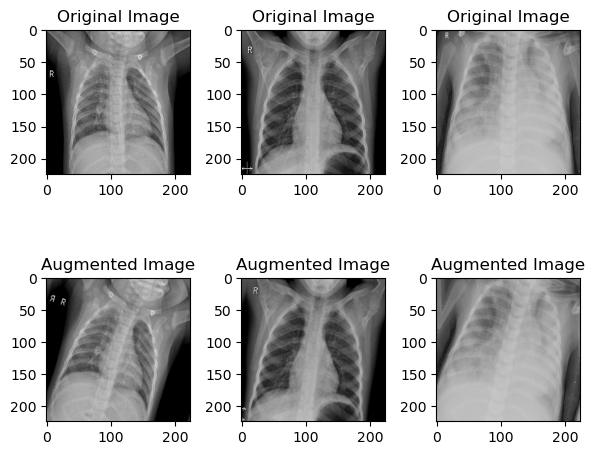

In [11]:
j=0
fig=plt.figure(figsize=(6, 6))
for i in (4,5,-1):
    fig.add_subplot(2,3,j+1)
    plt.imshow(train[i][0])
    plt.title("Original Image")
    x = augmentation_layers(train[i][0])
    fig.add_subplot(2,3,j+4)
    plt.imshow(x)
    plt.title("Augmented Image")
    plt.tight_layout()
    j+=1
plt.show()

# Calculating weights

In [12]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.73
Weight for class 1: 0.27


# Callbacks

In [13]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               mode='min')

# Metrics

In [14]:
def visualise_model_metrics(model, history):
    evaluation = model.evaluate(x=X_test,y=y_test)
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

    evaluation = model.evaluate(x=X_train,y=y_train)
    print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")
    
    plt.figure(figsize=(20,15))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label = "Training accuracy",marker='o')
    plt.plot(history.history['val_accuracy'], label="Validation accuracy",marker='o')
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(2,2,2)
    plt.plot(history.history['loss'], label = "Training loss",marker='o')
    plt.plot(history.history['val_loss'], label="Validation loss",marker='o')
    plt.legend()
    plt.title("Training vs validation loss")

    plt.show()

## Classification report function

In [15]:
def load_classification_report(y_pred):
    print('Classification report')
    print()
    print(classification_report(y_true=y_test,y_pred=y_pred, target_names=labels))

## Plotting ROC function

In [16]:
def plot_roc(y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# ResNet50

In [17]:
base_resnet50 = tf.keras.applications.ResNet50(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet50.layers:
        layer.trainable=False

94765736/94765736 [==============================] - 1s 0us/step


In [18]:
inputs = keras.layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet50(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1,activation='sigmoid')(x)
resnet50 = keras.Model(inputs, predictions)

In [19]:
resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [20]:
checkpoint_resnet50 = '/kaggle/working/resnet50_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet50,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_res50 = resnet50.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet50.load_weights(checkpoint_resnet50)

Epoch 1/30
163/163 [==============================] - 32s 101ms/step - loss: 0.0969 - accuracy: 0.8890 - val_loss: 0.4408 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 15s 89ms/step - loss: 0.0595 - accuracy: 0.9387 - val_loss: 0.1632 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 15s 90ms/step - loss: 0.0531 - accuracy: 0.9456 - val_loss: 0.1084 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - 14s 88ms/step - loss: 0.0476 - accuracy: 0.9523 - val_loss: 0.1479 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 15s 91ms/step - loss: 0.0428 - accuracy: 0.9534 - val_loss: 0.0733 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============================] - 15s 89ms/step - loss: 0.0478 - accuracy: 0.9515 - val_loss: 0.0886 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 7/30
163/163 [=============

20/20 [==============================] - 3s 114ms/step - loss: 0.2867 - accuracy: 0.8942
Test Accuracy: 89.42%
163/163 [==============================] - 15s 90ms/step - loss: 0.2229 - accuracy: 0.9099
Train Accuracy: 90.99%


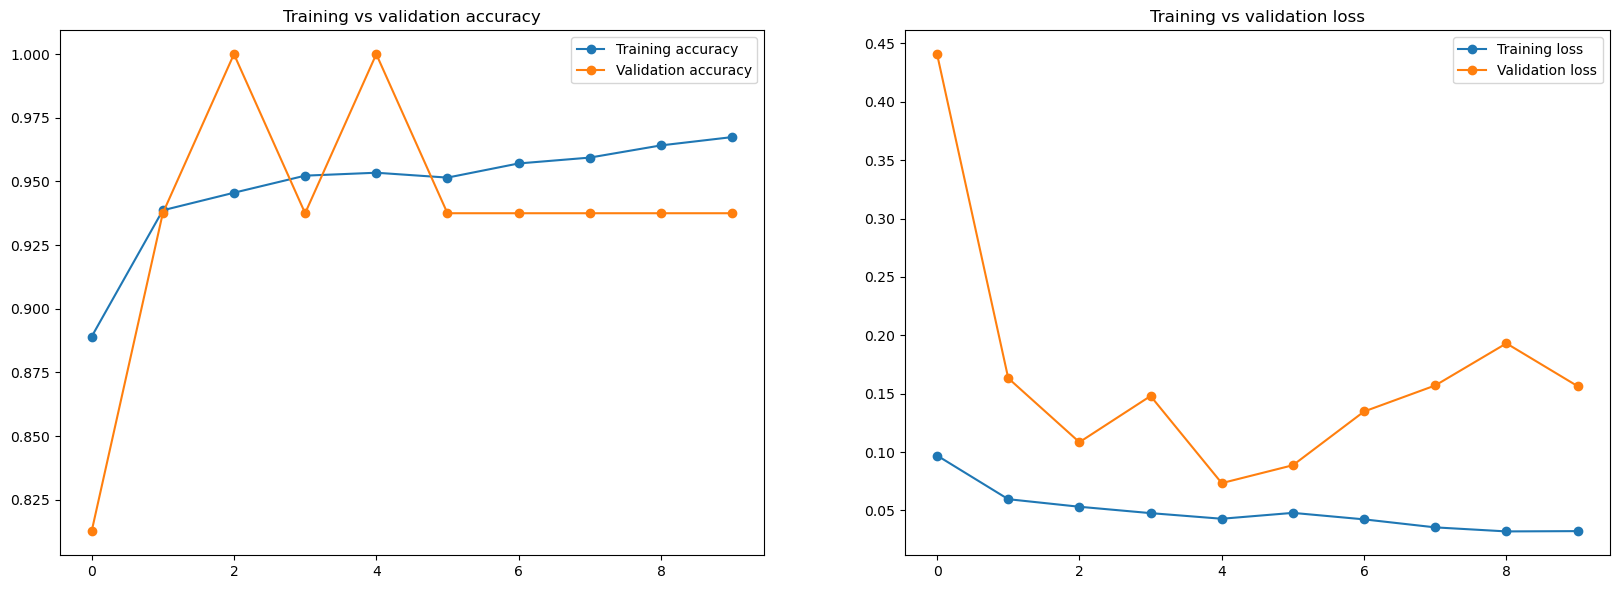

In [21]:
visualise_model_metrics(resnet50, history_res50)

20/20 [==============================] - 3s 89ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.86      0.85      0.86       234
   PNEUMONIA       0.91      0.92      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624



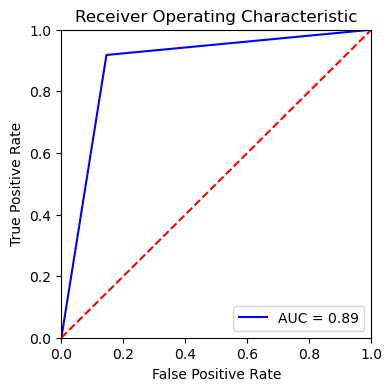

In [22]:
pred = resnet50.predict(X_test)
resnet50_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet50_pred)
plot_roc(resnet50_pred)

# ResNet101

In [23]:
base_resnet101 = tf.keras.applications.ResNet101(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet101.layers:
        layer.trainable=False

171446536/171446536 [==============================] - 1s 0us/step


In [24]:
inputs = keras.layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet101(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
resnet101 = keras.Model(inputs, predictions)

In [25]:
resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [26]:
checkpoint_resnet101 = '/kaggle/working/resnet101_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet101,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_resnet101 = resnet101.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet101.load_weights(checkpoint_resnet101)

Epoch 1/30
163/163 [==============================] - 35s 169ms/step - loss: 0.1066 - accuracy: 0.8800 - val_loss: 0.2684 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 26s 157ms/step - loss: 0.0647 - accuracy: 0.9319 - val_loss: 0.2193 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 25s 151ms/step - loss: 0.0601 - accuracy: 0.9387 - val_loss: 0.3896 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9471
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 25s 151ms/step - loss: 0.0506 - accuracy: 0.9471 - val_loss: 0.3510 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 25s 152ms/step - loss: 0.0454 - accuracy: 0.9526 - val_loss: 0.2670 - val_accuracy: 0.9375 - lr: 6.0000e-05
Epoch 6/30
163/163 [=========

20/20 [==============================] - 5s 149ms/step - loss: 0.3325 - accuracy: 0.8878
Test Accuracy: 88.78%
163/163 [==============================] - 25s 152ms/step - loss: 0.1197 - accuracy: 0.9513
Train Accuracy: 95.13%


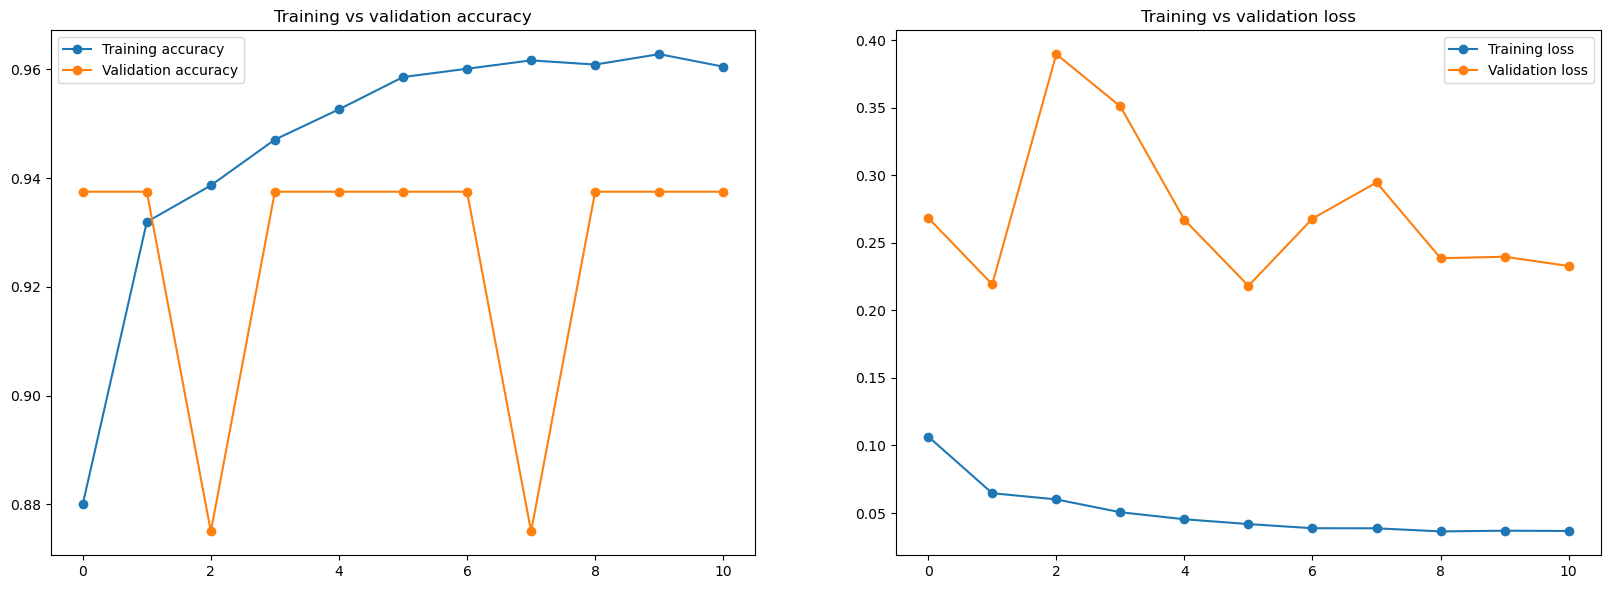

In [27]:
visualise_model_metrics(resnet101, history_resnet101)

20/20 [==============================] - 5s 149ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.92      0.76      0.84       234
   PNEUMONIA       0.87      0.96      0.91       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.89      0.89      0.89       624



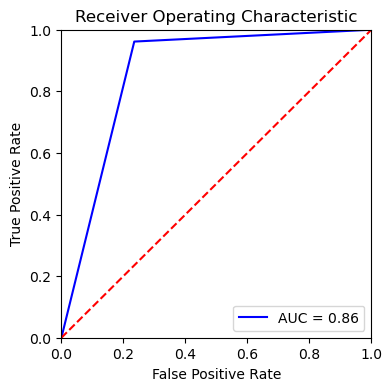

In [28]:
pred = resnet101.predict(X_test)
resnet101_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet101_pred)
plot_roc(resnet101_pred)

# ResNet152

In [29]:
base_resnet152 = tf.keras.applications.ResNet152(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet152.layers:
        layer.trainable=False

234698864/234698864 [==============================] - 1s 0us/step


In [30]:
inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet152(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
resnet152 = keras.Model(inputs, predictions)

In [31]:
resnet152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [32]:
checkpoint_resnet152 = '/kaggle/working/resnet152_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet152,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_resnet152 = resnet152.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet152.load_weights(checkpoint_resnet152)

Epoch 1/30
163/163 [==============================] - 48s 240ms/step - loss: 0.0983 - accuracy: 0.8928 - val_loss: 0.3498 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 36s 223ms/step - loss: 0.0648 - accuracy: 0.9360 - val_loss: 0.2509 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 35s 216ms/step - loss: 0.0543 - accuracy: 0.9471 - val_loss: 0.3532 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9467
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 35s 216ms/step - loss: 0.0526 - accuracy: 0.9467 - val_loss: 0.2584 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 35s 216ms/step - loss: 0.0447 - accuracy: 0.9542 - val_loss: 0.3783 - val_accuracy: 0.9375 - lr: 6.0000e-05
Epoch 6/30
163/163 [=========

20/20 [==============================] - 8s 211ms/step - loss: 0.2747 - accuracy: 0.9119
Test Accuracy: 91.19%
163/163 [==============================] - 36s 218ms/step - loss: 0.1358 - accuracy: 0.9431
Train Accuracy: 94.31%


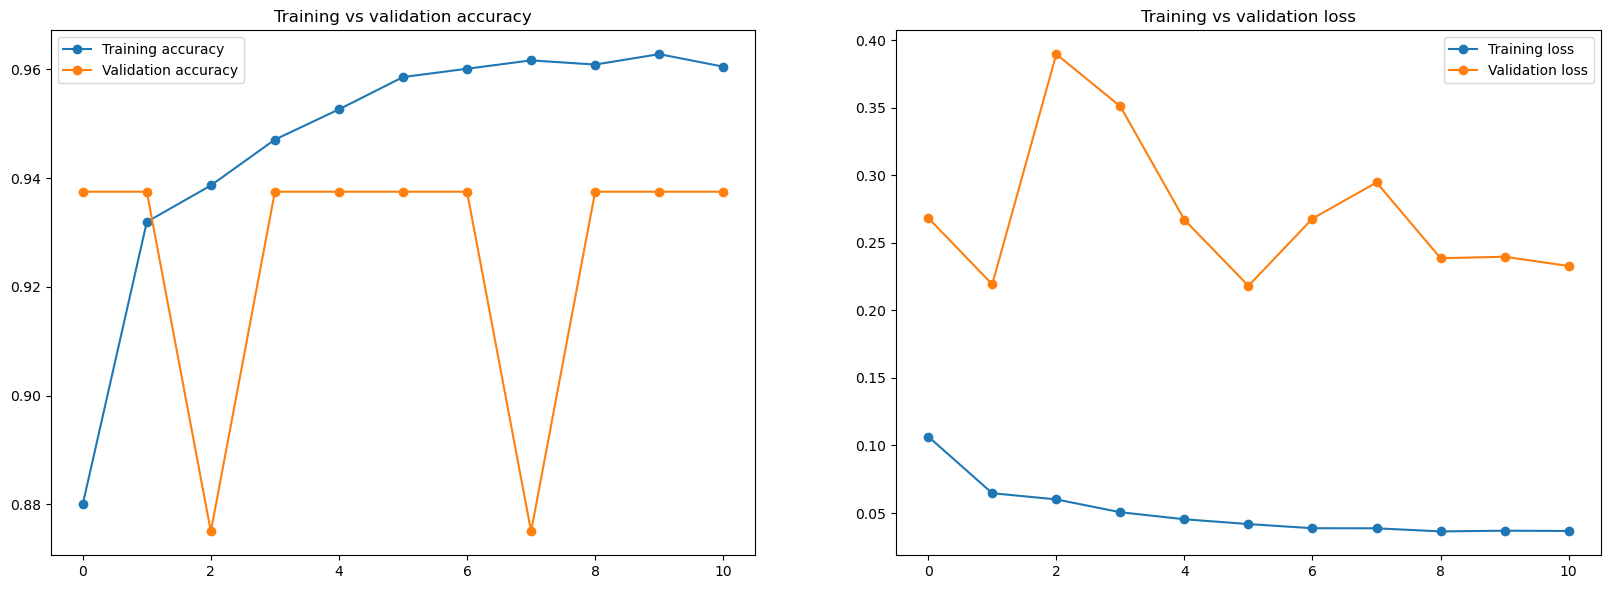

In [33]:
visualise_model_metrics(resnet152, history_resnet101)

20/20 [==============================] - 7s 213ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.93      0.83      0.88       234
   PNEUMONIA       0.90      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



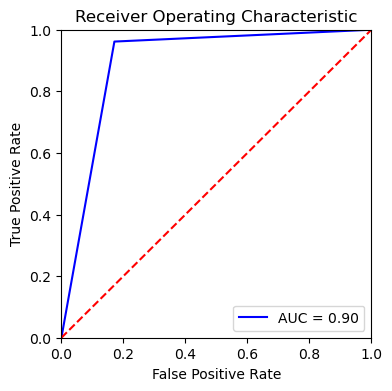

In [34]:
pred = resnet152.predict(X_test)
resnet152_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet152_pred)
plot_roc(resnet152_pred)

# DenseNet121

In [35]:
base_densenet121 = tf.keras.applications.DenseNet121(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_densenet121.layers:
        layer.trainable=False

29084464/29084464 [==============================] - 0s 0us/step


In [36]:
inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_densenet121(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
densenet121 = keras.Model(inputs, predictions)

In [37]:
densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [38]:
checkpoint_densenet121 = '/kaggle/working/densenet121_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_densenet121,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_densenet121 = densenet121.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

densenet121.load_weights(checkpoint_densenet121)

Epoch 1/30
163/163 [==============================] - 26s 109ms/step - loss: 0.2495 - accuracy: 0.7057 - val_loss: 0.7592 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 15s 90ms/step - loss: 0.1639 - accuracy: 0.8146 - val_loss: 0.6615 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 14s 88ms/step - loss: 0.1352 - accuracy: 0.8495 - val_loss: 1.1262 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.8668
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 14s 87ms/step - loss: 0.1219 - accuracy: 0.8668 - val_loss: 1.6695 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 14s 87ms/step - loss: 0.1119 - accuracy: 0.8767 - val_loss: 1.0889 - val_accuracy: 0.6875 - lr: 6.0000e-05
Epoch 6/30
163/163 [=============

20/20 [==============================] - 5s 144ms/step - loss: 0.4428 - accuracy: 0.8093
Test Accuracy: 80.93%
163/163 [==============================] - 14s 88ms/step - loss: 0.4408 - accuracy: 0.8121
Train Accuracy: 81.21%


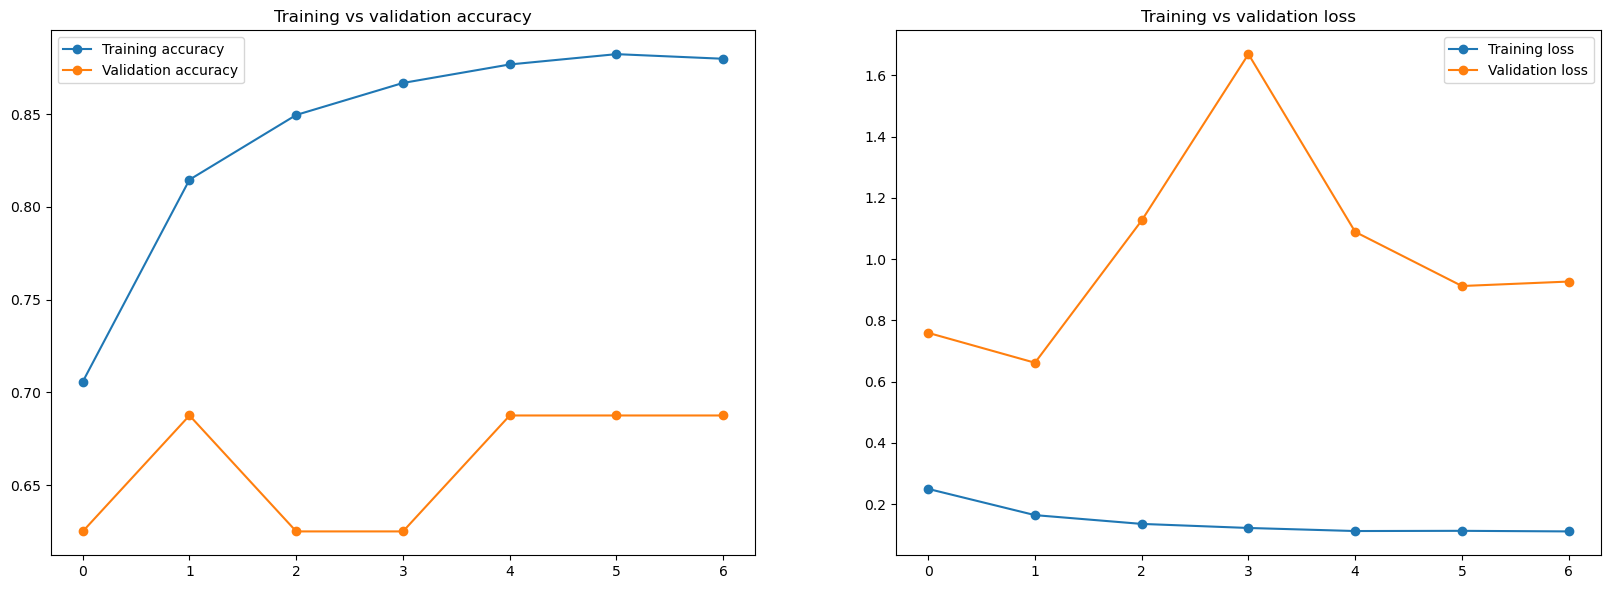

In [39]:
visualise_model_metrics(densenet121, history_densenet121)

20/20 [==============================] - 3s 86ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.70      0.85      0.77       234
   PNEUMONIA       0.90      0.78      0.84       390

    accuracy                           0.81       624
   macro avg       0.80      0.82      0.80       624
weighted avg       0.83      0.81      0.81       624



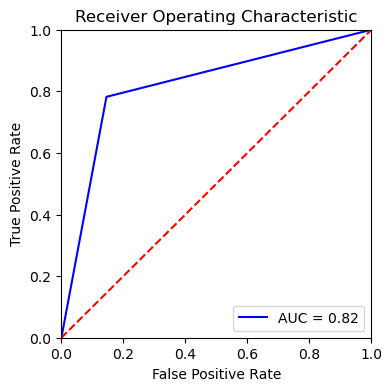

In [40]:
pred = densenet121.predict(X_test)
densenet121_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(densenet121_pred)
plot_roc(densenet121_pred)

# DenseNet169

In [41]:
base_densenet169 = tf.keras.applications.DenseNet169(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_densenet169.layers:
        layer.trainable=False

inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_densenet169(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
densenet169 = keras.Model(inputs, predictions)

51877672/51877672 [==============================] - 0s 0us/step


In [42]:
densenet169.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [43]:
checkpoint_densenet169 = '/kaggle/working/densenet169_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_densenet169,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_densenet169 = densenet169.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

densenet169.load_weights(checkpoint_densenet169)

Epoch 1/30
163/163 [==============================] - 31s 131ms/step - loss: 0.1964 - accuracy: 0.7793 - val_loss: 0.7327 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 18s 108ms/step - loss: 0.1270 - accuracy: 0.8627 - val_loss: 0.7556 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 18s 111ms/step - loss: 0.1137 - accuracy: 0.8800 - val_loss: 0.5297 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - 17s 107ms/step - loss: 0.1043 - accuracy: 0.8846 - val_loss: 0.7315 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 18s 111ms/step - loss: 0.0943 - accuracy: 0.8980 - val_loss: 0.5017 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============================] - 18s 111ms/step - loss: 0.0943 - accuracy: 0.8997 - val_loss: 0.4279 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 7/30
163/163 [========

20/20 [==============================] - 5s 137ms/step - loss: 0.3321 - accuracy: 0.8782
Test Accuracy: 87.82%
163/163 [==============================] - 18s 108ms/step - loss: 0.1799 - accuracy: 0.9160
Train Accuracy: 91.60%


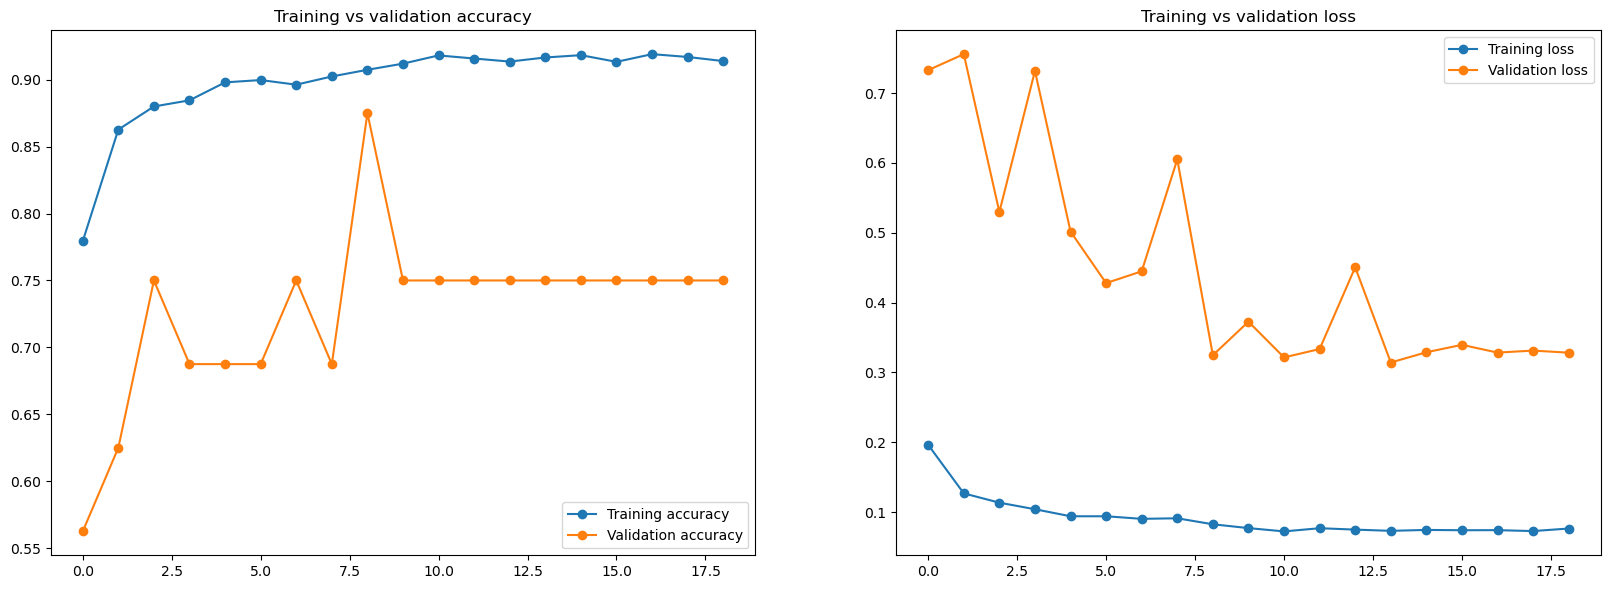

In [44]:
visualise_model_metrics(densenet169, history_densenet169)

20/20 [==============================] - 5s 109ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.87      0.79      0.83       234
   PNEUMONIA       0.88      0.93      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



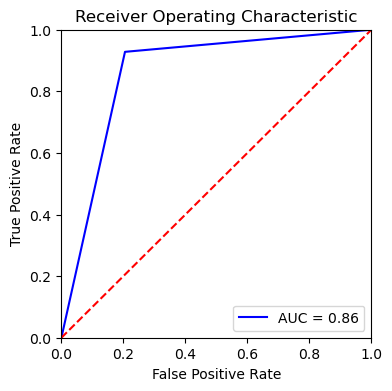

In [45]:
pred = densenet169.predict(X_test)
densenet169_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(densenet169_pred)
plot_roc(densenet169_pred)

# DenseNet201

In [46]:
base_densenet201 = tf.keras.applications.DenseNet201(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_densenet201.layers:
        layer.trainable=False

inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_densenet201(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
densenet201 = keras.Model(inputs, predictions)

74836368/74836368 [==============================] - 0s 0us/step


In [47]:
densenet201.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [48]:
checkpoint_densenet201 = '/kaggle/working/densenet201_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_densenet201,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_densenet201 = densenet201.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

densenet201.load_weights(checkpoint_densenet201)

Epoch 1/30
163/163 [==============================] - 39s 168ms/step - loss: 0.1868 - accuracy: 0.7851 - val_loss: 0.6958 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 23s 144ms/step - loss: 0.1249 - accuracy: 0.8650 - val_loss: 0.3669 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 22s 137ms/step - loss: 0.1108 - accuracy: 0.8758 - val_loss: 0.6613 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.8834
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 22s 137ms/step - loss: 0.1033 - accuracy: 0.8834 - val_loss: 0.5207 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 22s 137ms/step - loss: 0.0953 - accuracy: 0.8955 - val_loss: 0.4358 - val_accuracy: 0.8125 - lr: 6.0000e-05
Epoch 6/30
163/163 [=========

20/20 [==============================] - 7s 168ms/step - loss: 0.3866 - accuracy: 0.8510
Test Accuracy: 85.10%
163/163 [==============================] - 23s 139ms/step - loss: 0.2155 - accuracy: 0.9011
Train Accuracy: 90.11%


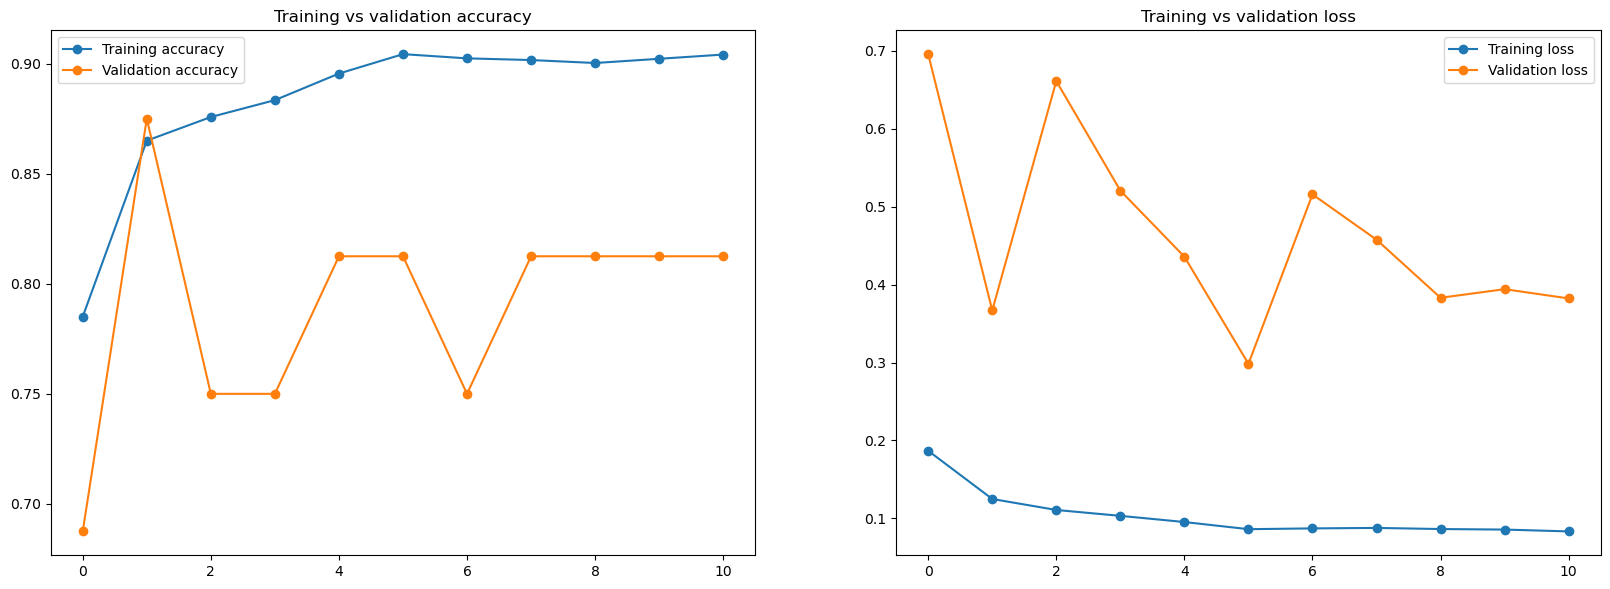

In [49]:
visualise_model_metrics(densenet201, history_densenet201)

20/20 [==============================] - 6s 136ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.80      0.80      0.80       234
   PNEUMONIA       0.88      0.88      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



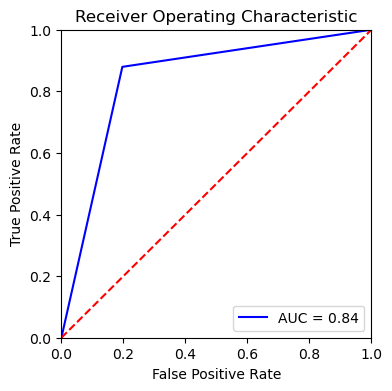

In [50]:
pred = densenet201.predict(X_test)
densenet201_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(densenet201_pred)
plot_roc(densenet201_pred)

# Metrics comparison

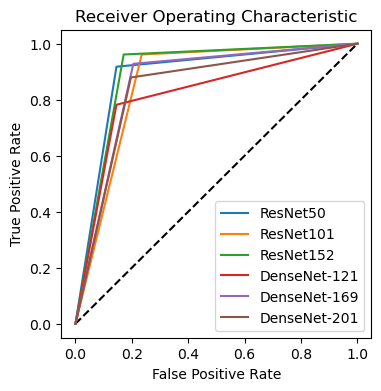

In [51]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, resnet50_pred)
fpr2, tpr2, thresholds2 = roc_curve(y_test, resnet101_pred)
fpr3, tpr3, thresholds3 = roc_curve(y_test, resnet152_pred)
fpr4, tpr4, thresholds4 = roc_curve(y_test, densenet121_pred)
fpr5, tpr5, thresholds5 = roc_curve(y_test, densenet169_pred)
fpr6, tpr6, thresholds6 = roc_curve(y_test, densenet201_pred)

plt.figure(figsize=(4, 4))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "ResNet50")
plt.plot(fpr2, tpr2, label= "ResNet101")
plt.plot(fpr3, tpr3, label= "ResNet152")
plt.plot(fpr4, tpr4, label= "DenseNet-121")
plt.plot(fpr5, tpr5, label= "DenseNet-169")
plt.plot(fpr6, tpr6, label= "DenseNet-201")

plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.show()

In [52]:
def print_scores(y_pred):    
    accuracy  = accuracy_score(y_test, y_pred)
    precision  = precision_score(y_test, y_pred)
    recall  = recall_score( y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_pred)
    print("Accuarcy Score: ", format(accuracy*100, '.2f'))
    print("Precision Score: ", format(precision*100, '.2f'))
    print("Recall Score: ", format(recall*100, '.2f'))
    print("F1 Score: ", format(f1*100, '.2f'))
    print("ROC AUC Score: ", format(roc*100, '.2f'))
    print("")

In [53]:
print("ResNet50")
print_scores(resnet50_pred)
print("ResNet101")
print_scores(resnet101_pred)
print("ResNet152")
print_scores(resnet152_pred)
print("DenseNet-121")
print_scores(densenet121_pred)
print("DenseNet-169")
print_scores(densenet169_pred)
print("DenseNet-201")
print_scores(densenet201_pred)

ResNet50
Accuarcy Score:  89.42
Precision Score:  91.33
Recall Score:  91.79
F1 Score:  91.56
ROC AUC Score:  88.63

ResNet101
Accuarcy Score:  88.78
Precision Score:  87.21
Recall Score:  96.15
F1 Score:  91.46
ROC AUC Score:  86.32

ResNet152
Accuarcy Score:  91.19
Precision Score:  90.36
Recall Score:  96.15
F1 Score:  93.17
ROC AUC Score:  89.53

DenseNet-121
Accuarcy Score:  80.93
Precision Score:  89.97
Recall Score:  78.21
F1 Score:  83.68
ROC AUC Score:  81.84

DenseNet-169
Accuarcy Score:  87.82
Precision Score:  88.29
Recall Score:  92.82
F1 Score:  90.50
ROC AUC Score:  86.15

DenseNet-201
Accuarcy Score:  85.10
Precision Score:  88.17
Recall Score:  87.95
F1 Score:  88.06
ROC AUC Score:  84.15

